# Improving performance

There are different ways to improve performance of a Python program. In ICS 46 you will learn about improving an algorithm through static analysis. Today, we are going to learn about how to improve performance from the hardware's point of view. Some of the concepts that we will learn today will be revisited in further courses, but it is imperative that as a future developer you learn what tools you have at your disposal.

## Hardware

Let's think about your hardware. Your code will at least run in a personal computer. These have what is called an architecture, a way the components interact with each other. The architecture is usually defined by the processor (CPU), and we are a long way since we had single threaded CPUs.

CPUs with multiple cores have become the standard in the recent development of modern computer architectures and we can not only find them in supercomputer facilities but also in our desktop machines at home, and our laptops; even Apple’s iPhone 5S got a 1.3 Ghz Dual-core processor in 2013.

However, the default Python interpreter was designed with simplicity in mind and has a thread-safe mechanism, the so-called “GIL” (Global Interpreter Lock). In order to prevent conflicts between threads, it executes only one statement at a time (so-called serial processing, or single-threading).


### Vectorization
One of the properties of many multi-core processors is the ability to process multiple points of data in a single pass. There's a name for these processors and it is SIMD (Single instruction multiple data). The process of transforming a code into it's SIMD form is called vectorization. With it we use a special kind of local parallelism available in multi core processors and it is the main source of their effectiveness. 

The following image represents how a simple operation such as addign two numbers can be sped up using SIMD instructions. While in scalar processing, each addition would be done after the previous one, using vector registers we can load up two n numbers (where n is the size of integers a vector register can hold) and apply addition to all of them at the same time.

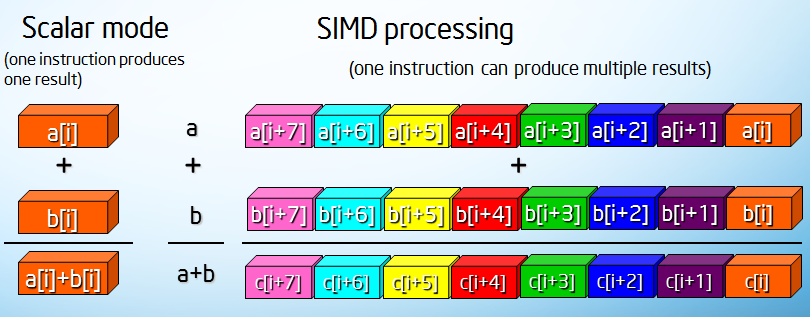



## Interlude: Profiling

Before we go any further and start looking at how vectorization makes your program faster, we need to talk about profiling. Profiling is the act of measuring performance of a program, either by timing it or by looking into memory access, depending on what is you are trying to measure.

(Follow the instructions here: https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html to setup the profilers)

### Time

This is the most common profiler. In a python code you just import the time module and measure starting and ending time. For IPython we can call the %time %%time and %%timeit magic

In [1]:
%time?

In [6]:
%%timeit
total = 0
for i in range(1000):
    for j in range(1000):
        total += i * (-1) ** j

396 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%time
total = 0
for i in range(1000):
    for j in range(1000):
        total += i * (-1) ** j

Wall time: 506 ms


In [9]:
import random
L = [random.random() for i in range(100000)]
print("sorting an unsorted list:")
%time L.sort()

sorting an unsorted list:
Wall time: 32 ms


In [10]:
print("sorting an already sorted list:")
%time L.sort()

sorting an already sorted list:
Wall time: 2.02 ms


Notice that sort() is way faster once a list is already sorted. You can see the different usage of time, timeit runs the code several times and return the statistics for all the runs.

### Prun

A program is made of many single statements, and sometimes timing these statements in context is more important than timing them on their own. Python contains a built-in code profiler (which you can read about in the Python documentation), but IPython offers a much more convenient way to use this profiler, in the form of the magic function %prun.

In [11]:
%prun?

In [12]:
def sum_of_lists(N):
    total = 0
    for i in range(5):
        L = [j ^ (j >> i) for j in range(N)]
        total += sum(L)
    return total

In [13]:
%prun sum_of_lists(1000000)

The result is a table that indicates, in order of total time on each function call, where the execution is spending the most time. In this case, the bulk of execution time is in the list comprehension inside sum_of_lists. From here, we could start thinking about what changes we might make to improve the performance in the algorithm.

### Memit

This profiler requires you to install memory_profiler. The memit magic allows us to measure memory performance of a given code.



In [20]:
%load_ext memory_profiler

In [21]:
%memit sum_of_lists(1000000)

peak memory: 134.28 MiB, increment: 75.79 MiB


We see that this function uses about 100 MB of memory.

For a line-by-line description of memory use, we can use the %mprun magic. Unfortunately, this magic works only for functions defined in separate modules rather than the notebook itself, so we'll start by using the %%file magic to create a simple module called mprun_demo.py, which contains our sum_of_lists function, with one addition that will make our memory profiling results more clear:

In [22]:
%%file mprun_demo.py
def sum_of_lists(N):
    total = 0
    for i in range(5):
        L = [j ^ (j >> i) for j in range(N)]
        total += sum(L)
        del L # remove reference to L
    return total

Writing mprun_demo.py


In [23]:
from mprun_demo import sum_of_lists
%mprun -f sum_of_lists sum_of_lists(1000000)

*** KeyboardInterrupt exception caught in code being profiled.


## Intel Distribution for Python

Now that we have learned about profiling, let's go back to hardware optimization. Since Python is an interpreted language, that means there is no compiler doing code optimizations when running on a machine. However, not everything in Python is Python. Many libraries use C as a backend language. For example, Numpy, a very popular library for numerical computations, is compiled using C, and can take the advantages that a compiled language provides, so that whenever you call on the Numpy module you can run an optimized version of it. 

(IDP is not the only distribution that optimizes Python. look into Numba and PyPy for other examples).

IDP optimizes modules by implementing optimizations such as vectorization. This allows us to run a big number of computations with a reduced running time. Let's go to the script called intelsample to see how intel is faster than typical python.

### Why is it  faster

Intel gets this acceleration by focusing on three things:

1. Taking advantage of multicore
2. Taking advantage of vector (also called SIMD) instructions such as SSE, AVX, AVX2, and AVX-512
3. Using advanced algorithms in the Intel® Math Kernel Library (Intel® MKL)

All three of these happen in programs that operate on vectors or matrices.  We shouldn’t expect big speed-ups for an occasional standalone cosine (that is, not in a loop cycle). Nor should we expect as much speed-up on a single core processor as on a multicore one.

### Setup

The easiest way to setup IDP is through anaconda. For the instructions let's go here: https://software.intel.com/en-us/articles/intel-distribution-for-python-development-environment-setting-for-jupyter-notebook-and

## Parallel computing

ICS 131 deals with parallel computing in detail. You are highly encouraged to take that course even if you don't plan to graduate with a parallel computing minor.

Let's talk about parallelism.

### Concurrency

In programming, concurrency is the composition of independently executing processes, while parallelism is the simultaneous execution of (possibly related) computations. Concurrency is about dealing with lots of things at once. Parallelism is about doing lots of things at once.

We will not look into concurrency but it is a topic usually taught along with parallelism. Though this sentence sums it up perfectly.

### Parallel vs serial

So far you have done single tasks step by step. This is called serial computing because there is a series of steps taken form the beginning of our code to the very end. Parallel computing is a change in paradigm where you have several process doing similar steps on different section of the data. Each process runs on their own clock and usually don't depend on the other processes

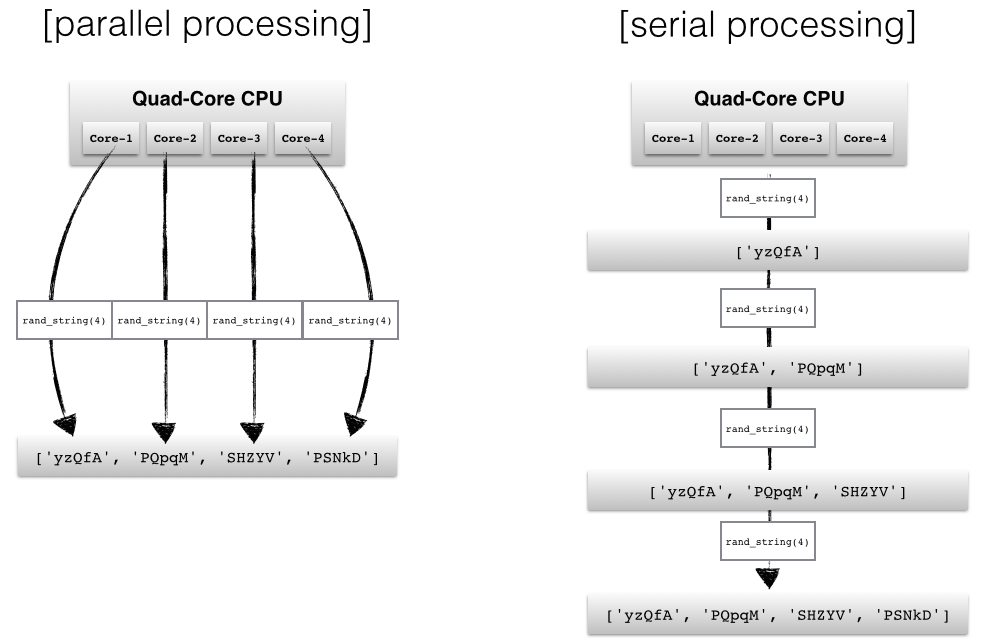

### Threads vs process

A thread is a sequence of instructions within a process. It can be thought of as a lightweight process. Threads share the same memory space.

A process is an instance of a program running in a computer which can contain one or more threads. A process has its independent memory space.

#### Python's GIL

The CPython implementation has a Global Interpreter Lock (GIL) which allows only one thread to be active in the interpreter at once. This means that threads cannot be used for parallel execution of Python code. While parallel CPU computation is not possible, parallel IO operations are possible using threads. This is because performing IO operations releases the GIL. 

### Multi-threading vs Multi-processing

Notice, the separation of these two concepts is almost exclusive to Python becaus of the GIL. In languages like C there's technically no difference between the two concepts

Depending on the application, two common approaches in parallel programming are either to run code via threads or multiple processes, respectively. If we submit “jobs” to different threads, those jobs can be pictured as “sub-tasks” of a single process and those threads will usually have access to the same memory areas (i.e., shared memory). Another approach is to submit multiple processes to completely separate memory locations (i.e., distributed memory): Every process will run completely independent from each other.

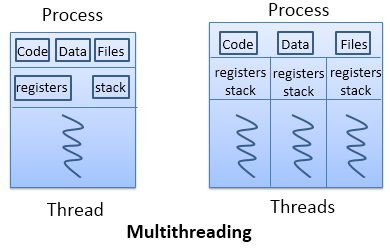

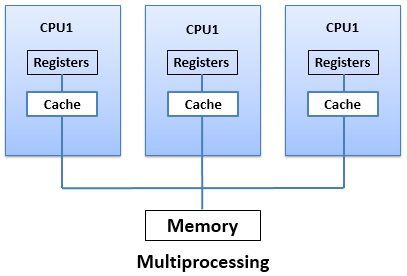

Threads should not be used for CPU bound tasks. Using threads for CPU bound tasks will actually result in worse performance compared to using a single thread.

Let me demonstrate why it’s a bad idea to use threads for CPU bound tasks. In the following program a queue holds numbers. The task is to find the sum of prime number less than or equal to the given number. This is clearly a CPU bound task.

In [5]:
%%file prime.py

def sum_prime(num):
    
    sum_of_primes = 0

    ix = 2

    while ix <= num:
        if is_prime(ix):
            sum_of_primes += ix
        ix += 1

    return sum_of_primes

def is_prime(num):
    if num <= 1:
        return False
    elif num <= 3:
        return True
    elif num%2 == 0 or num%3 == 0:
        return False
    i = 5
    while i*i <= num:
        if num%i == 0 or num%(i+2) == 0:
            return False
        i += 6
    return True


Overwriting prime.py


In [4]:
import threading
from queue import Queue
import time

list_lock = threading.Lock()

def find_rand(num):
    sum_of_primes = 0

    ix = 2

    while ix <= num:
        if is_prime(ix):
            sum_of_primes += ix
        ix += 1

    sum_primes_list.append(sum_of_primes)

def is_prime(num):
    if num <= 1:
        return False
    elif num <= 3:
        return True
    elif num%2 == 0 or num%3 == 0:
        return False
    i = 5
    while i*i <= num:
        if num%i == 0 or num%(i+2) == 0:
            return False
        i += 6
    return True

def process_queue():
    while True:
        rand_num = min_nums.get()
        find_rand(rand_num)
        min_nums.task_done()

min_nums = Queue()

rand_list = [1000000, 2000000, 3000000]
sum_primes_list = list()

for i in range(3):
    t = threading.Thread(target=process_queue)
    t.daemon = True
    t.start()

start = time.time()

for rand_num in rand_list:
    min_nums.put(rand_num)

min_nums.join()

end_time = time.time()

sum_primes_list.sort()
print(sum_primes_list)

print("Execution time = {0:.5f}".format(end_time - start))

[37550402023, 142913828922, 312471072265]
Execution time = 17.40201


For parallel execution of tasks, the multiprocessing module can be used.

In the following example we take the same task used above and process the inputs in parallel using the multiprocessing module.

In [9]:
from multiprocessing import Pool
import time
import prime

In [10]:
if __name__ == '__main__':
    start = time.time()
    with Pool(4) as p:
        print(p.map(prime.sum_prime, [1000000, 2000000, 3000000]))
    print("Time taken = {0:.5f}".format(time.time() - start))

[37550402023, 142913828922, 312471072265]
Time taken = 10.09113


So using the multiprocessing module results in the full utilization of the CPU.

Here's another example where we are partitioning a loop into several threads. This can be done more elegantly using map function but we generate each process manually for analysis. The following loop is iterating through a two dimensional matrix, and is adding it's elements with those of another two dimensional matrix

In [1]:
def tsvclooppar(nstart, ntimes, LEN, a, c, listh):
    print(" starting" )
    for nl in range(nstart,ntimes-1):
        dot=0
        for i in listh:
            for j in listh:
                a[i,j]=a[i,j]+c[i,j]
    return 0

In [2]:
%%time
import numpy as np


if __name__=='__main__':
	LEN=500
	ntimes=500
	nstart=1
	h=list(range(1,ntimes-1))
	b=np.linspace(0, 500, LEN)
	g=[]
	for iterx in range (0,LEN):
    		g.append(b)

	a=np.array([[x for x in y] for y in g])

	c=np.array([[x for x in y] for y in g])
	tsvclooppar(1,500,LEN,a,c,h)

 starting
Wall time: 56.7 s


In [3]:
import multiprocessing  
import random
from multiprocessing import Pool
import defs

In [4]:
%%time
if __name__=='__main__':
	LEN=500
	ntimes=500
	nstart=1
	h=list(range(1,ntimes-1))
	b=np.linspace(0, 500, LEN)
	g=[]
	for iterx in range (0,LEN):
    		g.append(b)

	a=np.array([[x for x in y] for y in g])

	c=np.array([[x for x in y] for y in g])
	p1 = multiprocessing.Process(target=defs.tsvclooppar, args=(nstart,125,LEN, a,c,h,))
	p1.start()
	p2 = multiprocessing.Process(target=defs.tsvclooppar, args=(126,250,LEN, a,c,h,))
	p2.start()
	p3 = multiprocessing.Process(target=defs.tsvclooppar, args=(251,375,LEN, a,c,h,))
	p3.start()
	p4 = multiprocessing.Process(target=defs.tsvclooppar, args=(376,ntimes,LEN, a,c,h,))
	p4.start()
	p1.join()
	p2.join()
	p3.join()
	p4.join()

Wall time: 19.8 s


There's so much more to learn about multiprocessing, and we will continue on it tomorrow at the lab.